In [6]:
.1/1.6

0.0625

In [5]:
pow(2, 10)/pow(2, 20)

0.0009765625

### Setup

In [2]:
from __future__ import division
import numpy as np
import time
import math
import sys
from scipy import stats

# For browser notifications when code has completed
% load_ext jupyternotify

# For plotting
import matplotlib.pyplot as plt
% matplotlib inline

# Correctly represent infinity depending on python version
if sys.version_info[0] >= 3:
    inf = math.inf
else:
    inf = float("inf")

### Game Graph Class

In [3]:
# Node class
class node:
    '''A simple node in a binary tree'''
    def __init__(self, value=None, left=None, right=None, parent=None):
        self.value = value
        self.left = left
        self.right = right
        self.parent = parent

# Naive implementation        
def make_children(source):
    '''Creates and returns left and right children for source node'''
    left = node(parent=source)
    right = node(parent=source)
    source.left = left
    source.right = right
    return left, right

def make_tree(n):
    '''Builds a tree of depth n'''
    source = node()
    tree = [[] for i in range(n+1)]  # i is depth
    tree[0].append(source)
    # Add children depth-by-depth
    for i in range(n):
        for j in range(pow(2, i)):
            tree[i+1]+=make_children(tree[i][j])
    # Compute random leaf values
    for leaf in tree[-1]:
        leaf.value = 2*np.random.random()-1
    return tree

# Faster implementation
def make_tree_fast(n):
    '''Builds a tree of depth n without storing parent/child relationships'''
    # Create the root node
    source = [[node()]]
    
    # Create the middle levels of the tree
    nodes = [range(2**depth) for depth in range(1, n)]
    tree = [[node() for v in level] for level in nodes]

    # Create the leaves
    leaves = [[node(value=(2*np.random.random()-1)) for v in range(2**n)]]
            
    # Combine and return tree
    tree = source + tree + leaves
    return tree
    
# Utility functions
def print_tree(tree):
    '''Prints value of all nodes in tree by depth'''
    for depth, level in enumerate(tree):
        vals = [v.value for v in level]
        print('Depth {} has {} nodes: {}'.format(depth, len(vals), vals))
    print('')

def get_value(tree):    
    '''Returns value of root node'''
    return tree[0][0].value
    
def print_value(tree):
    '''Prints value of root node'''
    print('The value to the first player, Paul, is: {}'.format(get_value(tree)))

### Value Calculation

In [4]:
def DFS_visit(tree, depth=0, key=0, Paul=True):
    '''Computes the value for each node'''
    current_node = tree[depth][key]
    if not current_node.value:
        DFS_visit(tree, depth+1, 2*key, Paul=not Paul)  # Left
        DFS_visit(tree, depth+1, 2*key+1, Paul=not Paul)  # Right
        
        left_child = tree[depth+1][2*key]
        right_child = tree[depth+1][2*key+1]
        
        if left_child.value:
            if right_child.value:
                if Paul:  # Maximizing player
                    current_node.value = max(left_child.value, right_child.value)
                else:  # Minimizing player
                    current_node.value = min(left_child.value, right_child.value)   

def DFS_visit_fast(tree, depth=0, key=0, alpha=-inf, beta=inf, Paul=True):
    '''Computes the values for nodes with alpha-beta pruning to limit search'''
    current_node = tree[depth][key]
    if not current_node.value:
        left_child = tree[depth+1][2*key]
        right_child = tree[depth+1][2*key+1]

        if Paul:  # Maximizing player
            v = -inf
            
            # Left
            DFS_visit_fast(tree, depth+1, 2*key, alpha, beta, Paul=not Paul)
            v = max(v, left_child.value)
            alpha = max(alpha, v)
            
            # Right
            if beta > alpha:
                DFS_visit_fast(tree, depth+1, 2*key+1, alpha, beta, Paul=not Paul)
                v = max(v, right_child.value)
                alpha = max(alpha, v)
            
        else:  # Minimizing player
            v = inf
            
            # Left
            DFS_visit_fast(tree, depth+1, 2*key, alpha, beta, Paul=not Paul)
            v = min(v, left_child.value)
            beta = min(beta, v)
            
            # Right
            if beta > alpha:
                DFS_visit_fast(tree, depth+1, 2*key+1, alpha, beta, Paul=not Paul)
                v = min(v, right_child.value)
                beta = min(beta, v)

        current_node.value = v

### Example

In [4]:
# Example tree:
n = 4

t0 = time.time()
example = make_tree(n)
t1 = time.time()
print('Time to build tree of depth {} naively: {} sec'.format(n, t1 - t0))

t0 = time.time()
example = make_tree_fast(n)
leaves = example[-1]
t1 = time.time()
print('Time to build tree of depth {} more quickly: {} sec'.format(n, t1 - t0))

# Example calculation:                 
t0 = time.time()
DFS_visit(example)
t1 = time.time()
print('Time to compute values for tree of depth {} without alpha-beta pruning: {} sec'.format(n, t1 - t0))

example = make_tree_fast(n)
example[-1] = leaves  # Same values to compare with alpha-beta

t0 = time.time()
DFS_visit_fast(example)
t1 = time.time()
print('Time to compute values for tree of depth {} with alpha-beta pruning: {} sec'.format(n, t1 - t0))

print('')
if n < 5:
    print_tree(example)
print_value(example)

print('')    
if n < 5:
    print_tree(example)
print_value(example)

Time to build tree of depth 4 naively: 0.0 sec
Time to build tree of depth 4 more quickly: 0.0010025501251220703 sec
Time to compute values for tree of depth 4 without alpha-beta pruning: 0.0 sec
Time to compute values for tree of depth 4 with alpha-beta pruning: 0.0 sec

Depth 0 has 1 nodes: [0.34333009772388356]
Depth 1 has 2 nodes: [-0.7815654127474327, 0.34333009772388356]
Depth 2 has 4 nodes: [-0.7815654127474327, -0.17051822298610642, 0.5565461812553643, 0.34333009772388356]
Depth 3 has 8 nodes: [-0.860151249730343, -0.7815654127474327, -0.17051822298610642, None, 0.5565461812553643, -0.558859311643551, -0.4064138178331176, 0.34333009772388356]
Depth 4 has 16 nodes: [0.9602695885951622, -0.860151249730343, 0.22446607205856517, -0.7815654127474327, 0.3950887477393972, -0.17051822298610642, 0.7036502734250418, -0.8465246828526694, 0.5565461812553643, 0.7255743361783689, -0.558859311643551, 0.7786724285620494, -0.4064138178331176, -0.348148494068629, 0.34333009772388356, 0.765465306

### Simulations
#### 1 Advantage to playing last? Test the effect of parity of tree depth.

In [5]:
# Create the lists of even and odd depths to use
ks = np.random.randint(5, 10, 100)
even_numbers = 2*ks
plus_or_minus = np.random.choice((1, -1))
odd_numbers = even_numbers + plus_or_minus

# Build the trees
even_trees = [make_tree_fast(n) for n in even_numbers]
odd_trees = [make_tree_fast(n) for n in odd_numbers]
%notify -m "Tree building for even and odd trees"

# Compute values for the trees
for tree in even_trees + odd_trees:
    DFS_visit_fast(tree)
%notify -m "Value computation for even and odd trees"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
odd_values = [get_value(tree) for tree in odd_trees]
even_values = [get_value(tree) for tree in even_trees]
print('Mean value to Paul for odd trees: {}\nMean value to Paul for even trees: {}'.format(np.mean(odd_values), np.mean(even_values)))
stats.ttest_ind(odd_values, even_values, equal_var=False)
# No advantage to playing last if pvalue > 0.05
# Advantage to playing last if pvalue < 0.05

Mean value to Paul for odd trees: 0.25747012795038204
Mean value to Paul for even trees: -0.2228170980902363


Ttest_indResult(statistic=53.664161852236695, pvalue=1.2483813049820888e-119)

#### 2. Advantage to playing first? Run t-test on all results against 0.

In [7]:
values = odd_values + even_values
print('Mean value to Paul for odd and even trees: {}'.format(np.mean(values)))
stats.ttest_1samp(values, popmean=0)
# No advantage to playing first if pvalue > 0.05
# Advantage to playing first if pvalue < 0.05

Mean value to Paul for odd and even trees: 0.017326514930072853


Ttest_1sampResult(statistic=0.98452757832256066, pvalue=0.32605166659643692)

#### 3. Variance and 4. Plot distribution of results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

With depth of 15, the average value for the first player, Paul, is: 0.25
With depth of 15, the standard deviation for the value for the first player, Paul, is: 0.03


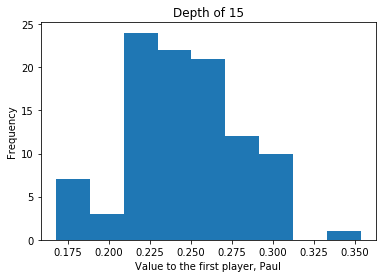

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

With depth of 16, the average value for the first player, Paul, is: -0.23
With depth of 16, the standard deviation for the value for the first player, Paul, is: 0.03


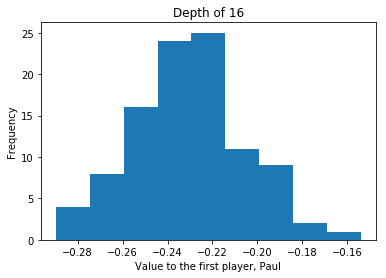

In [8]:
ns = [15]*100
trees15 = [make_tree_fast(n) for n in ns]
%notify -m "Tree building for variance analysis (part 1)"
for tree in trees15:
    DFS_visit_fast(tree)
%notify -m "Value computation for variance analysis (part 1)"
    
values = [get_value(tree) for tree in trees15]
print('With depth of %d, the average value for the first player, Paul, is: %.2f' % (ns[0], np.mean(values)))
print('With depth of %d, the standard deviation for the value for the first player, Paul, is: %.2f' % (ns[0], np.std(values)))

n, bins, patches = plt.hist(values, bins=9)
plt.xlabel('Value to the first player, Paul')
plt.ylabel('Frequency')
plt.title('Depth of %d' % ns[0])
plt.show()

ns = [16]*100
trees16 = [make_tree_fast(n) for n in ns]
%notify -m "Tree building for variance analysis (part 2)"
for tree in trees16:
    DFS_visit_fast(tree)
%notify -m "Value computation for variance analysis (part 2)"
    
values = [get_value(tree) for tree in trees16]
print('With depth of %d, the average value for the first player, Paul, is: %.2f' % (ns[0], np.mean(values)))
print('With depth of %d, the standard deviation for the value for the first player, Paul, is: %.2f' % (ns[0], np.std(values)))

n, bins, patches = plt.hist(values, bins=9)
plt.xlabel('Value to the first player, Paul')
plt.ylabel('Frequency')
plt.title('Depth of %d' % ns[0])
plt.show()

#### 5. Determine $\lim_{n\rightarrow \infty}Value[s]$

In [9]:
large_n = 20

t0 = time.time()
large_tree = make_tree_fast(large_n)
t1 = time.time()
print('Time to build tree of depth {}: {} sec'.format(large_n, t1 - t0))
%notify -m "Tree building for large n"

t0 = time.time()
DFS_visit_fast(large_tree)
t1 = time.time()
print('Time to compute values for tree of depth {} with alpha-beta pruning: {} sec'.format(large_n, t1 - t0))
%notify -m "Value computation for large n"

Time to build tree of depth 20: 2.7783894538879395 sec


<IPython.core.display.Javascript object>

Time to compute values for tree of depth 20 with alpha-beta pruning: 0.12232542037963867 sec


<IPython.core.display.Javascript object>